# Reeb Graph Matching
#### Implementing 'Topology Matching for Fully Automatic Similarity Estimation of 3D Shapes'
#### http://graphics.stanford.edu/courses/cs468-08-fall/pdf/Hilaga01.pdf
#### (Hilaga et al., 2001)

In [1]:
import numpy as np
import os
from os.path import isfile, join
from os import listdir
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csd_functions
import scipy
import networkx as nx
sns.set()


Load tree data

In [2]:
prefix = 'input_strength032320'
node_points, node_connectivity, node_color = csd_functions.load_tree(prefix)

Plot unprocessed critical point data

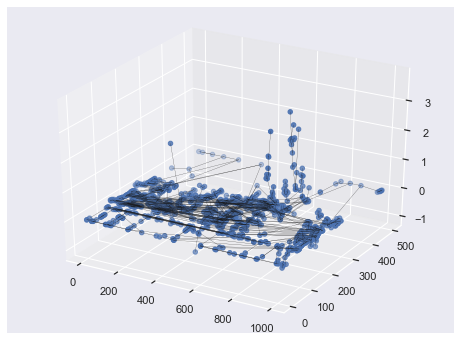

In [3]:
%matplotlib inline
fig = plt.figure(figsize = (8,6))
ax = plt.axes(projection='3d')

num_pairs = node_connectivity.shape[0]
for pair in range(num_pairs):
    pairID = node_connectivity[pair]
    pairID
    xdata, ydata, zdata = node_points[pairID, 0], node_points[pairID, 1], node_points[pairID, 2]

    ax.plot(xdata,ydata,zdata, 'k', linewidth=0.2)

num_points = node_points.shape[0]
ax.scatter(node_points[:, 0], node_points[:, 1], node_points[:, 2], 'b')

plt.show()

Resample tree to fit inside range

In [4]:
# adds or removes nodes based on interval
def edge_edit(B, start_node, end_node, interval_points):
    # print(str([start_node,end_node]))

    #Height of current node
    start_val = B.nodes[start_node]['Position'][2]
    end_val = B.nodes[end_node]['Position'][2]

    #Upper bound index for the start and ending node heights
    start_bound_idx, end_bound_idx = np.sum(interval_points < start_val), np.sum(interval_points < end_val)

    #Update node positions to center of interval
    B.nodes[start_node]['Position'][2] == np.mean(interval_points[start_bound_idx-1:start_bound_idx]) #*** Speed up with computing interval width ***
    B.nodes[end_node]['Position'][2] == np.mean(interval_points[end_bound_idx-1:end_bound_idx])

    #Represents how many intervals the edge spans
    bound_diff = abs(start_bound_idx - end_bound_idx)

    #Edge spans exactly 1 bound as desired, update node position and return
    if bound_diff == 1:
        print(str([start_node,end_node]), 'skip')

        return None

    #Connected nodes in same interval, merge together and update attribute dictionary
    elif bound_diff == 0:
        print(str([start_node,end_node]), 'merge')

        #Update attribute to indicate merging
        B.nodes[start_node]['Merged'].append(end_node)

        #Join end node neighbors to start node 
        merged_neighbors = list(B.neighbors(end_node))
        merged_neighbors.remove(start_node)
        B.remove_node(end_node)

        new_edges = [[start_node, new_neighbor] for new_neighbor in merged_neighbors]
        B.add_edges_from(new_edges)

        #update neighbors graph_search by reference

        return merged_neighbors

    #Edge spans more than one interval, subdivide
    elif bound_diff > 1:
        print(str([start_node,end_node]), 'insert')

        B.remove_edge(start_node, end_node)
        
        #Create new nodes with unique id's
        num_insertions = bound_diff-1
        max_node = max(list(B.nodes())) + 1 
        new_nodes = [start_node] + list(range(max_node + 1, max_node + num_insertions)) + [end_node]
        new_edges = [[new_nodes[i], new_nodes[i+1]] for i in range(len(new_nodes)-1)]

        #Update positions for new nodes
        new_height = [np.mean(interval_points[start_bound_idx-1 + i : start_bound_idx + i ]) for i in range(bound_diff+1)] 
        new_x = np.linspace(B.nodes[start_node]['Position'][0], B.nodes[end_node]['Position'][0], bound_diff+1)
        new_y = np.linspace(B.nodes[start_node]['Position'][1], B.nodes[end_node]['Position'][1], bound_diff+1)

        new_attributes = {new_nodes[idx] : {'Position' : [new_x[idx], new_y[idx],new_height[idx]], 'Visited' : 1, 'Merged':[],'Inserted':[]} for idx in range(1,len(new_nodes)-1)}

        #Insert connected nodes at center of interval
        B.add_edges_from(new_edges)
        nx.set_node_attributes(B,new_attributes)

        for node_idx in range(len(new_nodes)):
            B.node[new_nodes[node_idx]]['Inserted'].append(new_nodes)
     

        return None


In [5]:
#Recursive function that goes through all edges 
def graph_search(A, start, interval_points):
    if A.nodes[start]['Visited'] == 1:
        return
    else:
        A.nodes[start]['Visited'] = 1
        neighbors = list(A.neighbors(start))

        #Insert or remove nodes based on interval position
        for neighbor_id in neighbors:
            #If an edge was merged, the neighbor list updates to reflect new neighbors
            neighbor_update = edge_edit(A, start, neighbor_id, interval_points)
            if neighbor_update != None:
                neighbors.extend(neighbor_update)
                continue #Go on to next neighbor

            else:
                graph_search(A,neighbor_id,interval_points)
            

        
        return


        

Compute Intervals

In [6]:
#Number of level sets for reeb graph
num_intervals = 5

min_elevation, max_elevation = min(node_points[:,2]), max(node_points[:,2])
node_differences = np.sort(np.diff(np.sort(node_points[:,2]))) #Sorted list of height difference bettwen all nodes

interval_width = (max_elevation-min_elevation)/(num_intervals-1)
low, high = min_elevation - (interval_width/2), max_elevation + (interval_width/2)

#Centers the minimum and maximum nodes at the min and max intervals
interval_bound = [[low + interval_width*pos, low + interval_width*(pos+1)] for pos in range(num_intervals)]
interval_points = np.array([low + interval_width*pos for pos in range(num_intervals+1)])

In [7]:
G = nx.Graph()
G.add_edges_from(node_connectivity)

node_attributes = {node_id : {'Position' : node_points[node_id,:], 'Visited' : 0, 'Merged':[],'Inserted':[]} for node_id in list(G.nodes)}
nx.set_node_attributes(G,node_attributes)



Compute multiresoluion reeb graph

In [8]:
graph_search(G, 0, interval_points)

] merge
[0, 1124] merge
[0, 1036] merge
[0, 44] merge
[0, 1160] merge
[0, 1164] merge
[0, 1155] merge
[0, 1195] skip
[1195, 0] skip
[0, 1157] merge
[0, 1198] skip
[1198, 0] skip
[0, 1123] merge
[0, 1127] merge
[0, 43] merge
[0, 1068] merge
[0, 1067] merge
[0, 1018] merge
[0, 1017] merge
[0, 1016] merge
[0, 1015] merge
[0, 1010] merge
[0, 1009] merge
[0, 995] merge
[0, 994] merge
[0, 1012] merge
[0, 1011] merge
[0, 977] merge
[0, 976] merge
[0, 970] merge
[0, 969] merge
[0, 1295] merge
[0, 19] merge
[0, 1290] merge
[0, 18] merge
[0, 27] merge
[0, 991] merge
[0, 15] merge
[0, 26] merge
[0, 29] merge
[0, 990] merge
[0, 984] merge
[0, 14] merge
[0, 964] merge
[0, 28] merge
[0, 30] merge
[0, 983] merge
[0, 1002] merge
[0, 963] merge
[0, 1296] merge
[0, 17] merge
[0, 962] merge
[0, 960] merge
[0, 16] merge
[0, 21] merge
[0, 961] merge
[0, 968] merge
[0, 959] merge
[0, 947] merge
[0, 20] merge
[0, 23] merge
[0, 967] merge
[0, 972] merge
[0, 946] merge
[0, 25] merge
[0, 22] merge
[0, 31] merge

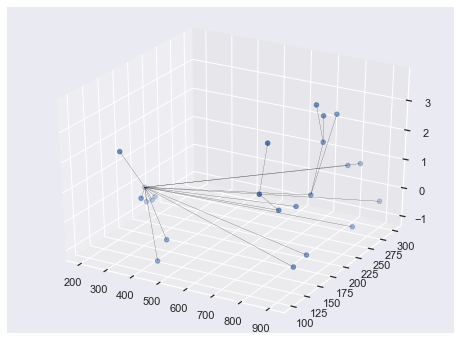

In [10]:
%matplotlib inline
csd_functions.plot_graph(G)
